In [1]:
#hivemind.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#3 March 2018
#
#This illustrates how to play the hivemind game...

In [2]:
#game settings
N_buckets = 50
N_turns = 10000
rn_seed = 14

In [3]:
#generate game data
from hivemind import *
bucket_yields, best_bucket, bucket_yield_mean, bucket_yield_sigma = play_hivemind(N_buckets, N_turns)
print bucket_yields[0]
print best_bucket[0]

[ 0.         -0.00044276  0.00037061  0.00061644  0.00044472  0.00032266
  0.00149414  0.00046861  0.00229553  0.00122054  0.00291307  0.00296612
  0.00183002  0.00576387  0.00387785  0.00663469  0.00243941  0.00785686
  0.01011842 -0.00047656  0.00553236 -0.00376005 -0.00077361  0.00432095
  0.00755527  0.00856208 -0.00114514  0.00903949  0.00059446  0.00310465
  0.01091477  0.00209048  0.00375728 -0.00558316  0.00218135 -0.00390568
  0.01123898  0.00772767  0.00702857  0.0015861  -0.00174216 -0.00200134
  0.00664047 -0.00115051 -0.00875479  0.01709015  0.00500607  0.0134708
  0.00444502 -0.00600565]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


In [4]:
#prep matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

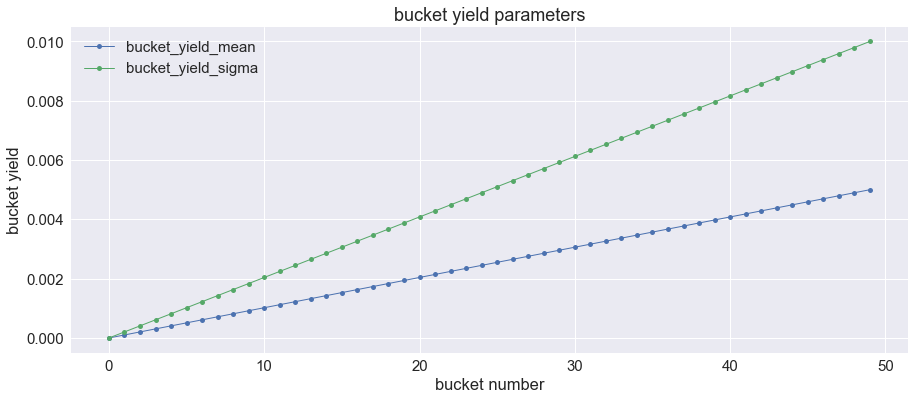

In [5]:
#plot loss vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = np.arange(N_buckets)
yp = bucket_yield_mean
ax.plot(xp, yp, linewidth=1, marker='o', markersize=5, label='bucket_yield_mean')
yp = bucket_yield_sigma
ax.plot(xp, yp, linewidth=1, marker='o', markersize=5, label='bucket_yield_sigma')
ax.set_title('bucket yield parameters')
ax.set_ylabel('bucket yield')
ax.set_xlabel('bucket number')
ax.legend()

In [6]:
#test-train-validation split is 1:1:1
train_fraction = 1.0/3.0
x = bucket_yields
y = best_bucket
from sklearn.model_selection import train_test_split
x_train, x_test_validate, y_train, y_test_validate = train_test_split(x, y, train_size=train_fraction, 
    test_size=(1-train_fraction), random_state=rn_seed)
train_fraction = 0.5
x_test, x_validate, y_test, y_validate = \
    train_test_split(x_test_validate, y_test_validate, train_size=train_fraction, random_state=rn_seed)
print x.shape, y.shape
print x_train.shape, y_train.shape
print x_test.shape, y_test.shape
print x_validate.shape, y_validate.shape

(10000, 50) (10000, 50)
(3333, 50) (3333, 50)
(3333, 50) (3333, 50)
(3334, 50) (3334, 50)


/Users/joe/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
#build MLP classification model 
N_inputs = x.shape[1]
N_outputs = y.shape[1]
N_middle_layer = (N_inputs + N_outputs)/2
dropout_fraction = 0.25
model = mlp_classifier(N_inputs, N_middle_layer, N_outputs, dropout_fraction)
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
Total params: 7,650
Trainable params: 7,650
Non-trainable params: 0
_________________________________________________________________


In [8]:
#train model to predict rewards
N_epochs = 200
batch_size = N_turns/100
dropout_fraction = 0.13
N_middle_layer = (N_inputs + N_outputs)/2
print 'layers = ', N_inputs, N_middle_layer, N_outputs
print 'dropout_fraction = ', dropout_fraction
model = mlp_classifier(N_inputs, N_middle_layer, N_outputs, dropout_fraction)
fit_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=N_epochs, verbose=0, 
    validation_data=(x_validate, y_validate))

layers =  50 50 50
dropout_fraction =  0.13


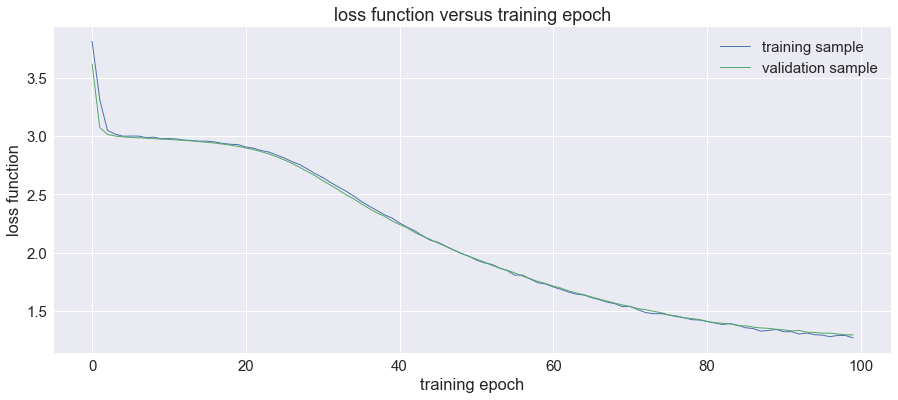

In [9]:
#plot loss vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, linewidth=1, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, linewidth=1, label='validation sample')
ax.set_title('loss function versus training epoch')
ax.set_ylabel('loss function')
ax.set_xlabel('training epoch')
ax.legend()

In [13]:
#play short game and use trained model to predict best_bucket_probability
N_turns = 100
bucket_yields, best_bucket, bucket_yield_mean, bucket_yield_sigma = play_hivemind(N_buckets, N_turns)
#print 'bucket_yields:'
#print bucket_yields

In [14]:
#compute ...
net_gains, best_bucket_probability = compute_net_gains(bucket_yields, model)
#print 'best_bucket_probability:'
#print best_bucket_probability
net_gains.tail()

,turn,gain0,gain1,gain2,gain3,gain4,gain5,gain6,gain7,gain8,...,prob42,prob43,prob44,prob45,prob46,prob47,prob48,prob49,net_gain,compound_gain
95,95,0.0,0.000012,-0.000030,0.000284,0.001006,0.000841,0.000663,0.000406,0.002969,...,0.000030,0.000488,2.152289e-02,0.000197,0.093005,0.877166,7.496568e-05,0.001184,1.027857,4.722026
96,96,0.0,0.000235,0.000609,-0.000293,0.000853,0.001126,0.000047,0.000010,-0.000177,...,0.517972,0.000192,9.344317e-05,0.000180,0.002114,0.000083,4.771363e-07,0.005741,1.014185,4.789006
97,97,0.0,0.000044,-0.000802,-0.000903,0.000893,0.001273,0.001143,0.000692,0.002380,...,0.301883,0.001045,5.306907e-04,0.000117,0.000003,0.000179,3.904818e-03,0.036219,1.008542,4.829916
98,98,0.0,0.000282,-0.000125,0.000331,0.000337,-0.000544,-0.000825,-0.001244,-0.000208,...,0.000387,0.000083,6.524626e-07,0.000039,0.000483,0.691092,3.457765e-05,0.000006,1.015767,4.906068
99,99,0.0,-0.000070,0.000199,-0.000258,0.000799,-0.001113,0.000247,0.000031,0.002378,...,0.053283,0.015674,8.487741e-02,0.005593,0.000002,0.000005,2.518732e-07,0.002922,1.013622,4.972898


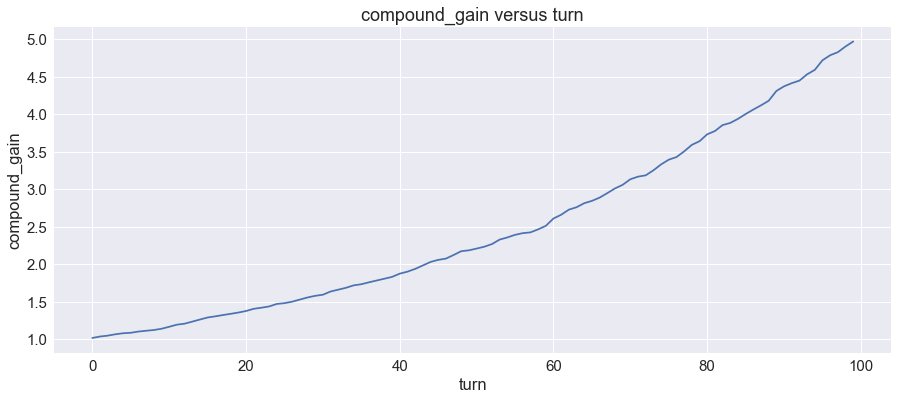

In [15]:
#plot loss vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
df = net_gains
xp = df['turn']
yp = df['compound_gain']
p = ax.plot(xp, yp)
p = ax.set_title('compound_gain versus turn')
p = ax.set_ylabel('compound_gain')
p = ax.set_xlabel('turn')